## Lab 5: Quantum Phase Estimation ##

The goal of the quantum phase estimation is to solve for $\theta$ in the eigenvalue problem $U | \psi \rangle = e^{2 \pi i \theta} | \psi \rangle$ given a unitary operator $U$ and a state $| \psi \rangle$. To do this, the phase of U is written into the three qubits in the counting register. Then, the inverse QFT translates from the fourier basis into computational basis so that it can be measured.

In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

### T-gate ###

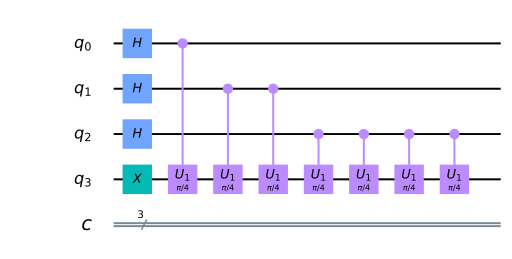

In [2]:
# quantum circuit

# the circuit contains 3 'counting' qubits in the top register, and the bottom register contains qubit in the state |psi>

# setup state in |1> 
qpe = QuantumCircuit(4, 3)
qpe.x(3) # X gate

# apply Hadamard on the counting register for superposition
for qubit in range(3):
    # Hadamard gates
    qpe.h(qubit)
    
# controlled unitary operations. Successive CU gates repeat the rotation until the phase of U, theta, is encoded in the fourier basis
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cu1(math.pi/4, counting_qubit, 3)
    repetitions *= 2    
    
qpe.draw(output='mpl')

In [3]:
# inverse QFT to convert state of counting register, where peak is near x = 2^n \theta

def qft_dagger(circ, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        circ.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            circ.cu1(-math.pi/float(2**(j-m)), m, j)
        circ.h(j)

In [4]:
qpe.barrier()

# Apply inverse QFT
qft_dagger(qpe, 3)

# measure counting register in reverse order
# When 2^n \theta is integer, measuring computational basis gives phase in top register with high probability
# When 2^n \theta not integer, peak still occurs near x = 2^n \theta with probability > .40
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)

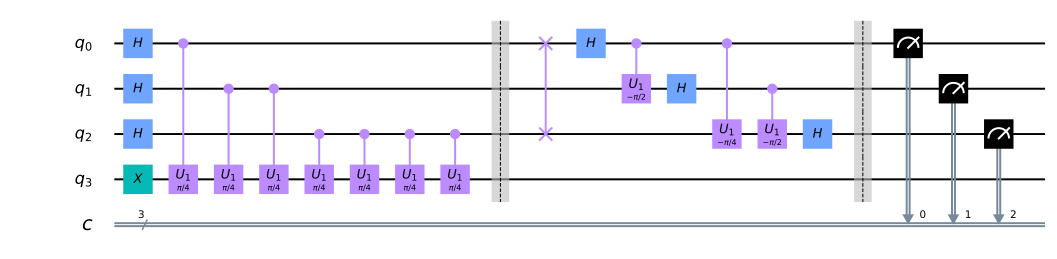

In [5]:
qpe.draw(output='mpl')

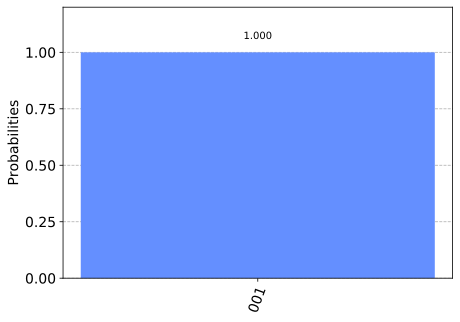

In [6]:
# run the circuit on simulator

backend = Aer.get_backend('qasm_simulator')
shots = 2048
results = execute(qpe, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We see $|001 \rangle = 1$ with complete certainty. To get $\theta$,
\begin{equation}
    \theta = \frac{1}{2^3} = \frac{1}{8}
\end{equation}
as expected.

### Getting More Precision ###

Now instead of T-gate, use gate with $\theta = \frac{1}{3}$

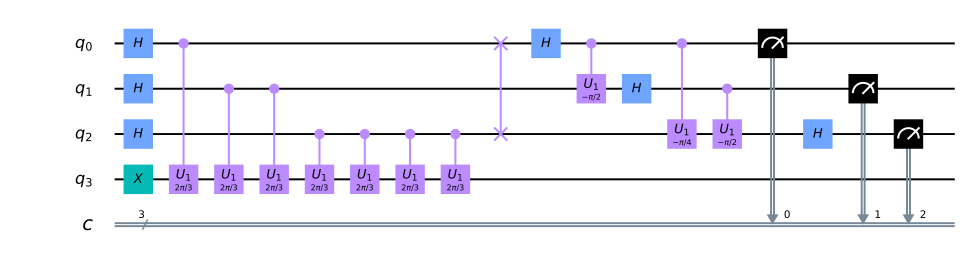

In [7]:
# create and set up circuit
qpe2 = QuantumCircuit(4,3)

# Apply H-Gates to counting qubits:
for qubit in range(3):
    qpe2.h(qubit)

# Prepare our eigenstate |psi>:
qpe2.x(3)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe2.cu1(angle, counting_qubit, 3);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe2, 3)

# Measure of course!
for n in range(3):
    qpe2.measure(n,n)

qpe2.draw(output='mpl')


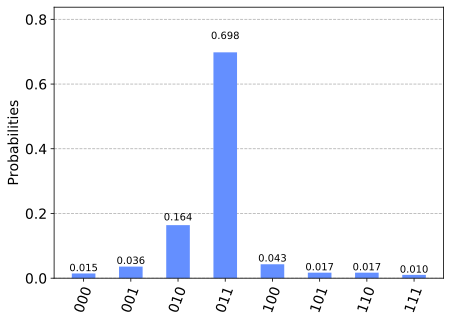

In [8]:
# see the result
backend = Aer.get_backend('qasm_simulator')
shots = 4096
results = execute(qpe2, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

Though we expect to see the result $\theta = \frac{1}{3}$, measurements show that the likely outcomes are 011 and 010, giving $\theta = \frac{1}{4}$ and $\theta = 0.375$. Clearly imprecise. To arrive at a more precise solution, add two more qubits

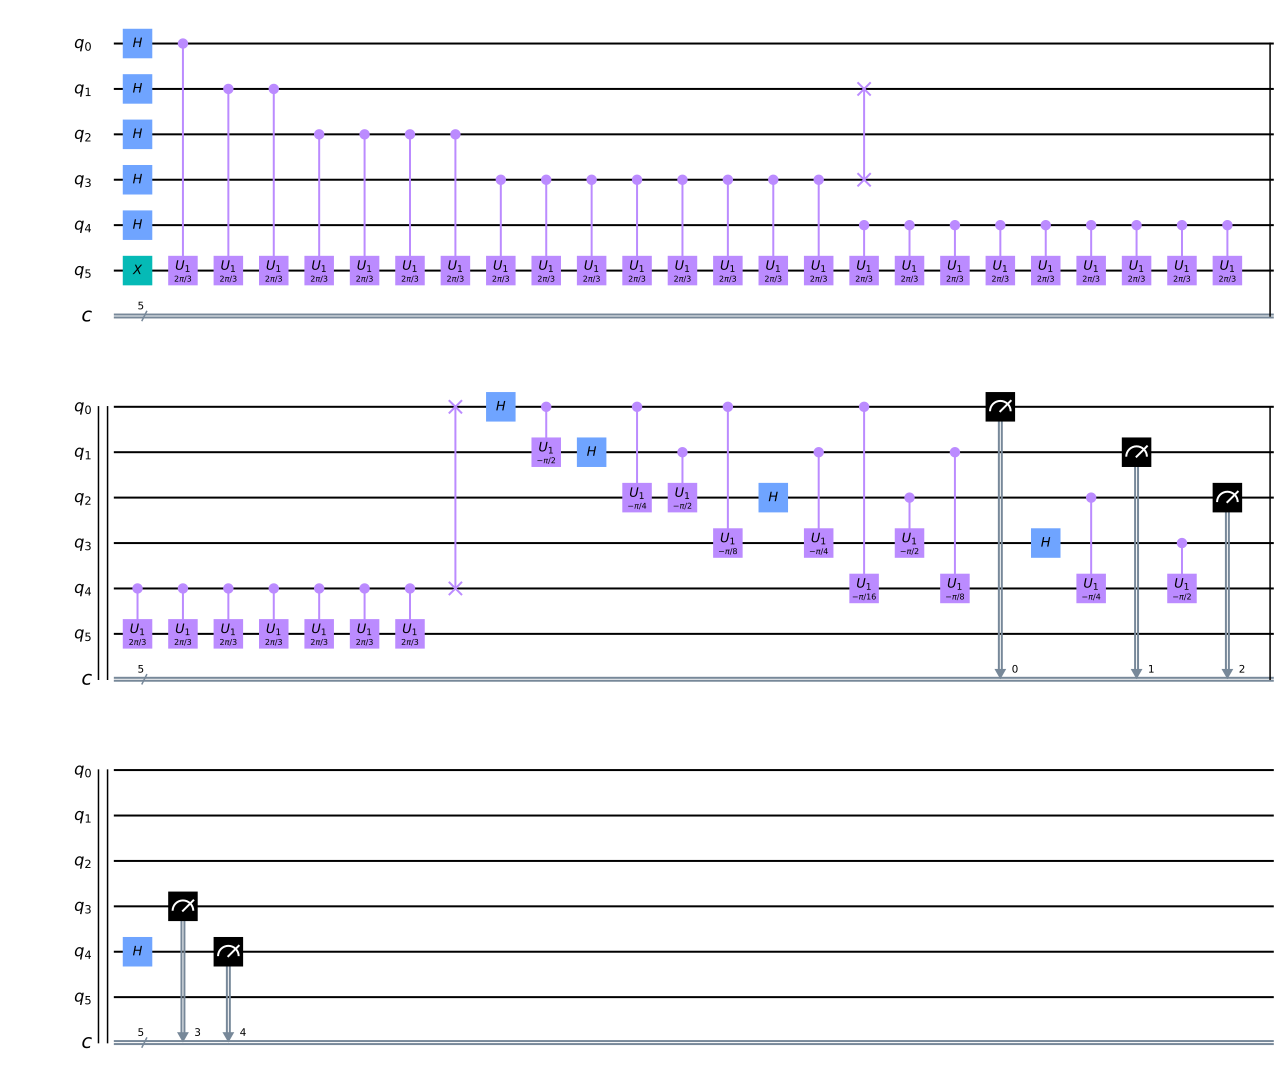

In [9]:
# Create and set up circuit
qpe3 = QuantumCircuit(6, 5)

# Apply H-Gates to counting qubits:
for qubit in range(5):
    qpe3.h(qubit)

# Prepare our eigenstate |psi>:
qpe3.x(5)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(5):
    for i in range(repetitions):
        qpe3.cu1(angle, counting_qubit, 5);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe3, 5)

# Measure
for n in range(5):
    qpe3.measure(n,n)

qpe3.draw(output='mpl')

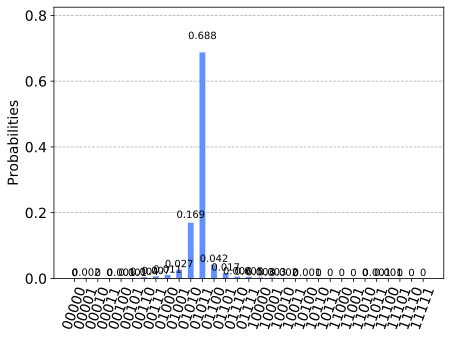

In [10]:
# see the results
backend = Aer.get_backend('qasm_simulator')
shots = 4096
results = execute(qpe3, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

Now, the two most probable are |01011> and |01010>. Measuring these results gives

\begin{equation}
\theta = \frac{11}{2^5} = 0.344,
\end{equation}
or, with lesser probability,
\begin{equation}
\theta = \frac{10}{2^5} = 0.313.
\end{equation}

The 6 qubit result is much more precise than with 4 qubits.

### Experiment with Real Devices ###

In [11]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to n qubits
IBMQ.load_account()
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 4 and not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Run with 2048 shots
shots = 2048
job = execute(qpe, backend=backend, shots=2048, optimization_level=3)
job_monitor(job)

least busy backend:  ibmq_ourense
Job Status: job has successfully run


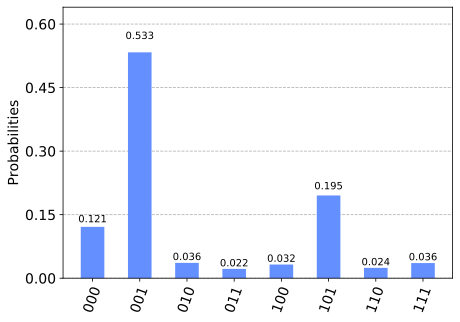

In [12]:
# get the results from the computation
results = job.result()
answer = results.get_counts(qpe)

plot_histogram(answer)

Unlike the simulator, there is a probability of measuring something other than |001> we can see the noise and gate errors in the quantum computer 

### Exercises ###

1. Try the experiments above with different gates ($\text{CNOT}$, $S$, $T^\dagger$), what results do you expect? What results do you get?

CNOT|1>|-> = $e^{i \pi}|1>|->$ can be simplified to $X|-> = e^{i \pi}|->$. 

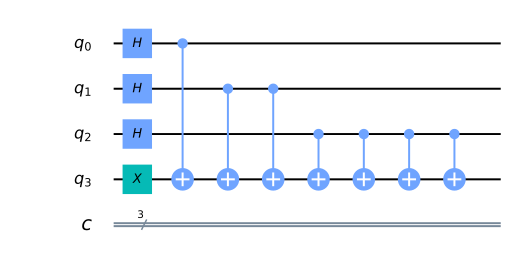

In [15]:
# quantum circuit

# setup state in |1> 
qpe_cnot = QuantumCircuit(4, 3)
qpe_cnot.x(3) # X gate

# apply Hadamard on the counting register for superposition
for qubit in range(3):
    # Hadamard gates
    qpe_cnot.h(qubit)
    
qpe_cnot.cnot(0,3)   
qpe_cnot.cnot(1,3)   
qpe_cnot.cnot(1,3)   
qpe_cnot.cnot(2,3)   
qpe_cnot.cnot(2,3)   
qpe_cnot.cnot(2,3)   
qpe_cnot.cnot(2,3)   



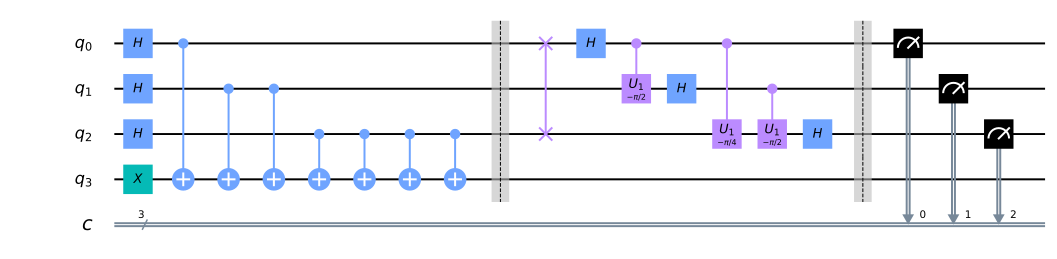

In [16]:
qpe_cnot.barrier()

# Apply inverse QFT
qft_dagger(qpe_cnot, 3)

qpe_cnot.barrier()
for n in range(3):
    qpe_cnot.measure(n,n)
    
qpe_cnot.draw(output='mpl')

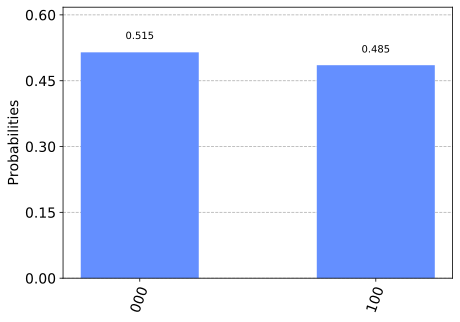

In [23]:
# run the circuit on simulator

backend = Aer.get_backend('qasm_simulator')
shots = 2048
results = execute(qpe_cnot, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

bin(000) = 0, bin(100) = 4 and $\theta = \frac{2}{2^3} = \frac{1}{4}, \text{and } \theta = \frac{4}{2^3} = \frac{1}{2}$

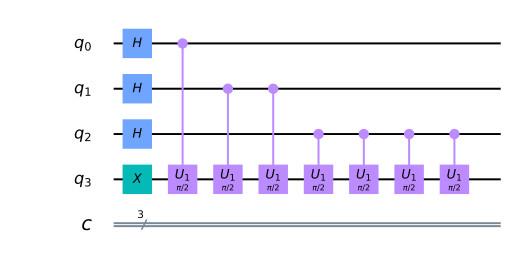

In [20]:
# quantum circuit

# setup state in |1> 
qpe_s = QuantumCircuit(4, 3)
qpe_s.x(3) # X gate

# apply Hadamard on the counting register for superposition
for qubit in range(3):
    # Hadamard gates
    qpe_s.h(qubit)

repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe_s.cu1(math.pi/2, counting_qubit, 3); # This is C-U
    repetitions *= 2
qpe_s.draw(output='mpl')



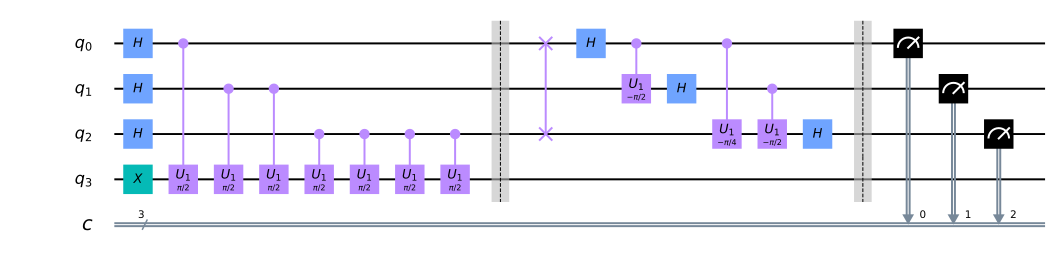

In [21]:
qpe_s.barrier()

# Apply inverse QFT
qft_dagger(qpe_s, 3)

# measure counting register in reverse order

qpe_s.barrier()
for n in range(3):
    qpe_s.measure(n,n)
    
qpe_s.draw(output='mpl')

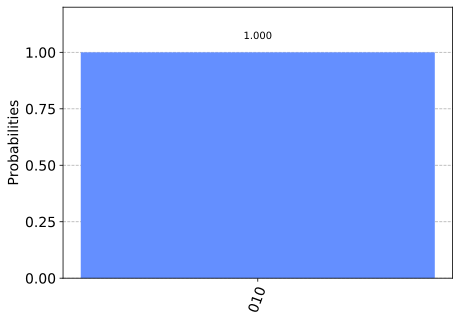

In [24]:
# run the circuit on simulator

backend = Aer.get_backend('qasm_simulator')
shots = 2048
results = execute(qpe_s, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

bin(010) = 2, and $\theta = \frac{2}{2^3} = \frac{1}{4}$

For $T^\dagger$, $T^\dagger |1> = e^{\frac{-i \pi}{4}} |1>$

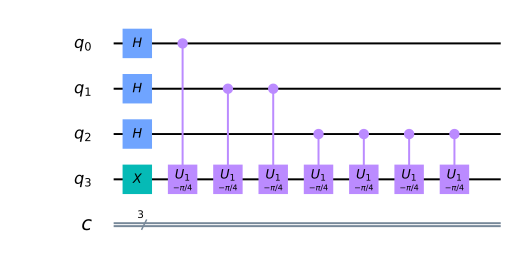

In [27]:
# quantum circuit

# setup state in |1> 
qpe_tdag = QuantumCircuit(4, 3)
qpe_tdag.x(3) # X gate

# apply Hadamard on the counting register for superposition
for qubit in range(3):
    # Hadamard gates
    qpe_tdag.h(qubit)

repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe_tdag.cu1(-math.pi/4, counting_qubit, 3); # This is C-U
    repetitions *= 2
qpe_tdag.draw(output='mpl')



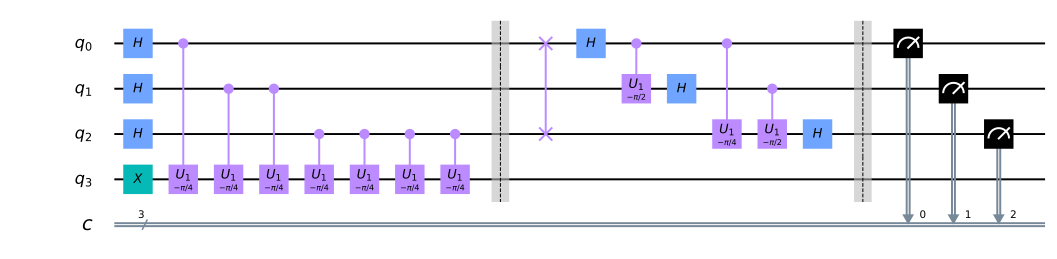

In [28]:
qpe_tdag.barrier()

# Apply inverse QFT
qft_dagger(qpe_tdag, 3)

# measure counting register in reverse order

qpe_tdag.barrier()
for n in range(3):
    qpe_tdag.measure(n,n)
    
qpe_tdag.draw(output='mpl')

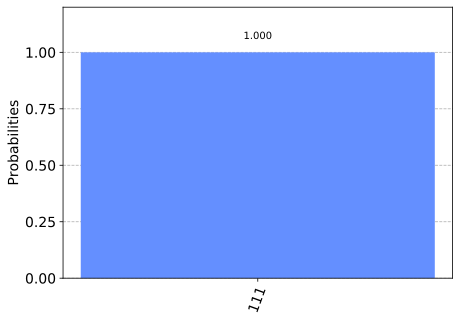

In [29]:
# run the circuit on simulator

backend = Aer.get_backend('qasm_simulator')
shots = 2048
results = execute(qpe_tdag, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

bin(111) = 7, and $\theta = \frac{7}{2^3} = \frac{7}{8}$. Let's try with more qubits

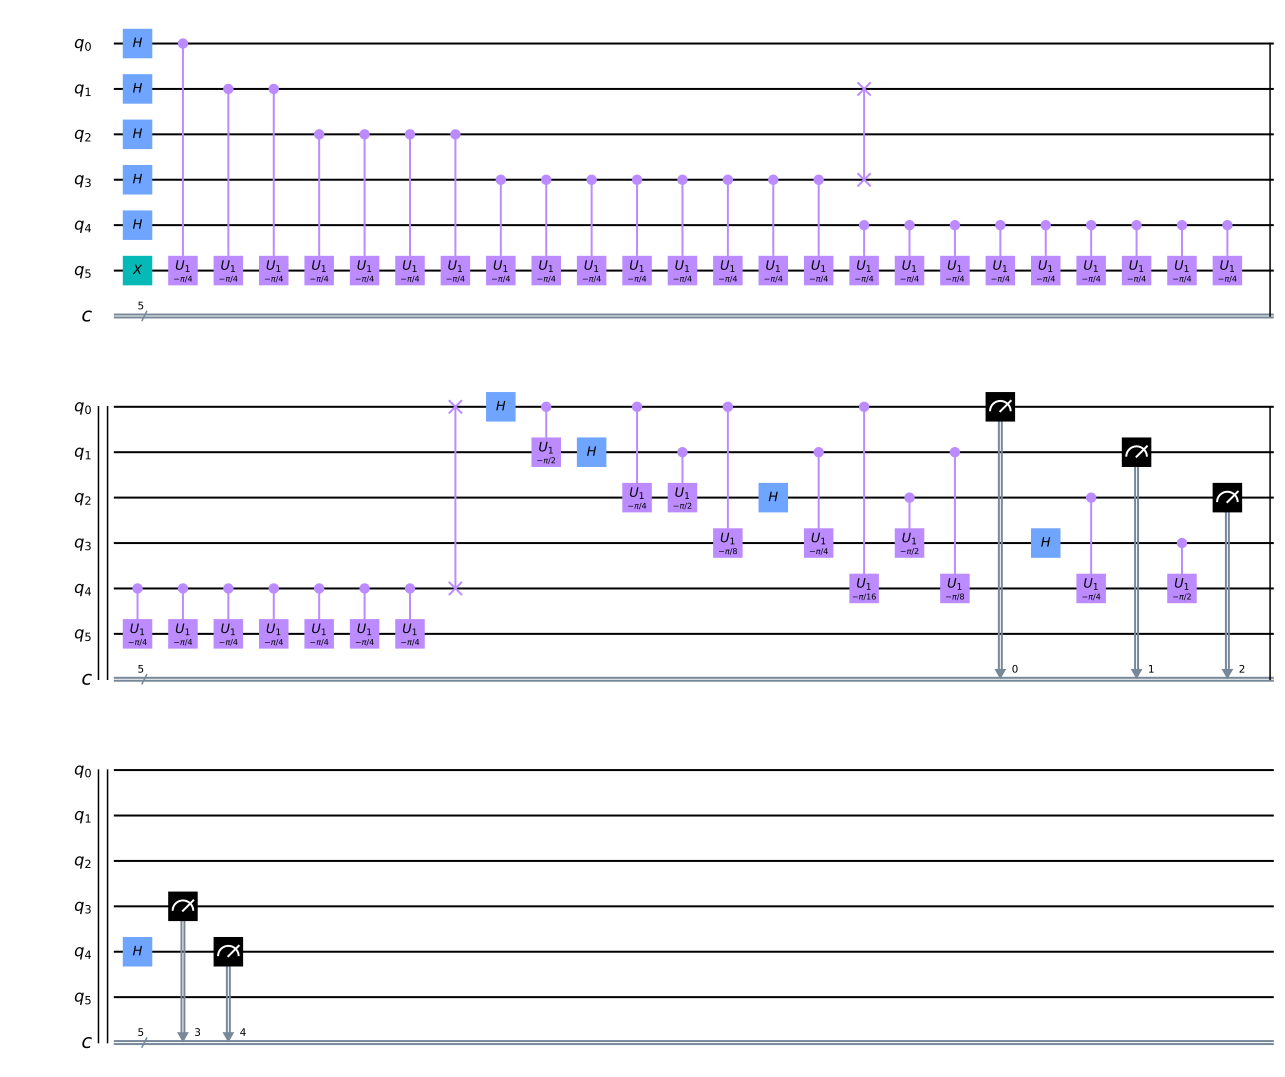

In [30]:
# Create and set up circuit
qpe_tdag2 = QuantumCircuit(6, 5)

# Apply H-Gates to counting qubits:
for qubit in range(5):
    qpe_tdag2.h(qubit)

# Prepare our eigenstate |psi>:
qpe_tdag2.x(5)

# Do the controlled-U operations:
angle = -math.pi/4
repetitions = 1
for counting_qubit in range(5):
    for i in range(repetitions):
        qpe_tdag2.cu1(angle, counting_qubit, 5);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe_tdag2, 5)

# Measure
for n in range(5):
    qpe_tdag2.measure(n,n)

qpe_tdag2.draw(output='mpl')

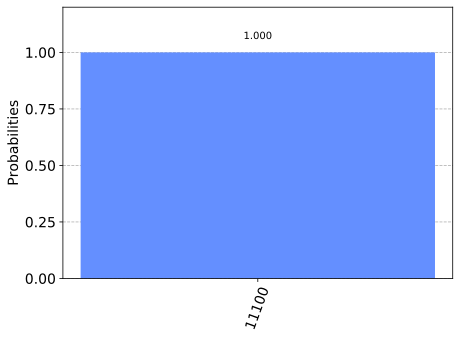

In [31]:
# see the results
backend = Aer.get_backend('qasm_simulator')
shots = 4096
results = execute(qpe_tdag2, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

bin(11100) = 28, and $\theta = \frac{28}{2^5} = \frac{28}{32} = \frac{7}{8}$. 

2. Try the experiment with a $Y$-gate, do you get the correct result? (Hint: Remember to make sure $|\psi\rangle$ is an eigenstate of $Y$!)

$$ Y|1\rangle = 
\begin{bmatrix}
0 & -i\\
i & 0 \\ 
\end{bmatrix}
\begin{bmatrix}
0\\
1\\ 
\end{bmatrix}
= \begin{bmatrix}
-i\\
i\\ 
\end{bmatrix} $$

$$ Y|0\rangle = 
\begin{bmatrix}
0 & -i\\
i & 0 \\ 
\end{bmatrix}
\begin{bmatrix}
1\\
0\\ 
\end{bmatrix}
= i \begin{bmatrix}
0\\
1\\ 
\end{bmatrix} 
= i|1\rangle$$